## Neural Network Categorical Classification, cardinality 3

This copy updates the 205000+ rows and has the ability to write it out as a CSV (uncomment and run the last code block).
This performs a sentiment analysis, trained on the original sentiments using Rate, Review and Price as predictor features.
A new column NN-sentiment is added and results are reported here:

There were a total of  46161  changes in sentiment
Accuracy against the full training set is  0.7748814934748259
 
Total changed from positive to neutral  0
Total changed from positive to negative  16941
Total changed from neutral to positive  8467
Total changed from neutral to negative  1732
Total changed from negative to neutral  0
Total changed from negative to positive  19021

I'm not saying this is better or worse (probably worse) than the original sentiments. What I'm suggesting is if some were to be double checked against other ways of examining the sentiment the results here suggest about 22% fall into the re-examination category.

This Notebook takes about 50 to 60 minutes to execute on the Kaggle servers.
It reports:
1282/1282 [==============================] - 2s 2ms/step - loss: 0.2881 - accuracy: 0.9170
Test accuracy: 0.9170466661453247
Test loss: 0.2881276607513428

Many thanks also to NIRALII VAGHANI AND 1 COLLABORATOR · UPDATED A MONTH AGO for the data.
It follows the design pattern in the Intro To Deep Learning tutorial here at Kaggle.
If you read through this, and the Tutorial, you'll find this is highly parallel in how the pipeline is built and used in the Tutorial on binary classification.
I watched one of Rob Mulla's videos related to this type of network a while back and got the basics for how to solve the 
classification problem for negative, neutral, and positive sentiment (flatten and then bring the connections together for each dummy created for the categorical output).
I asked ChatGPT/Bing for advice with Pandas and type conversion. Both gave about the same answer.

Here is how it works:
1. Lots of data cleansing, NaN and cannot convert string to float took most of the time to clean out.
2. It uses three features: product_price, Review, and Rate.
3. Rate is treated as a categorical feature and put through OneHot in the pipeline.
4. product_price is just a float and stays that way.
5. Review occurs 1324 times uniquely (most people say something similar to many others when just writing a few words).
5.1. The Python singleton class CatVarStorageLabels is used to keep a map of Review occurrences and a unique integer is assigned to each unique occurrence for use in the input vector (tensor).
5.2. The data from CatVarStorageLabels is written to a file. If a productized predictor were used the model would also need to be written to a file and loaded for use when required. Vectorization from CatVarStorageLabels's data would need to be added to the productized version. Use 0.0 if not found (0.0 was not included and thus should not contribute).

Yes, odds are using a sentiment detector on the Summary and Reviews, is probably better or added to this. With over 200,000 samples however, I felt this was a good data set for training a network.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## This notebook uses a Neural Network to attempt to predict the sentiment.

I am practicing and as such I'm sure experts will find flaws. I welcome your feedback.

Load the Flipkart data into a Pandas DataFrame

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

fkdf = pd.read_csv('/kaggle/input/flipkart-product-customer-reviews-dataset/Dataset-SA.csv')

Gather metrics and statistics on the data set in order to study it.

fkdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB
None
fkdf.isnull().any()
product_name     False
product_price    False
Rate             False
Review            True
Summary           True
Sentiment        False
dtype: bool
fkdf.isnull().sum()
product_name         0
product_price        0
Rate                 0
Review           24664
Summary             11
Sentiment            0
dtype: int64
fkdf.describe()

                                             product_name product_price  \
count                                          

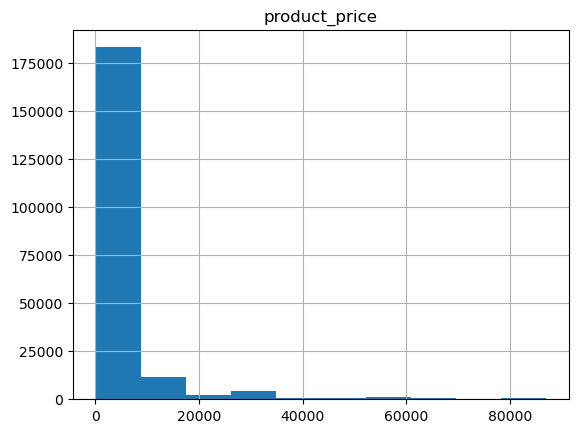

In [3]:
print ("fkdf.info()\n")
print (fkdf.info())
print ('fkdf.isnull().any()')
print (fkdf.isnull().any())
print ('fkdf.isnull().sum()')
print (fkdf.isnull().sum())
print ("fkdf.describe()\n")
print (fkdf.describe())
print ("fkdf.head()\n")
print (fkdf.head())
print ("fkdf.nunique()\n")
print (fkdf.nunique())

fkdf = fkdf[(fkdf.Rate !='Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)') & \
            (fkdf.Rate != "Bajaj DX 2 L/W Dry Iron") & \
            (fkdf.Rate !='Nova Plus Amaze NI 10 1100 W Dry Iron?ÃÂ¿?ÃÂ¿(Grey & Turquoise)')]
fkdf ['product_price'] = fkdf ['product_price'].astype(str).astype(int)

print ("fkdf.hist()\n")
print (fkdf.hist())

More data cleanup. So far, only 3 price entries were removed so that the histogram can be built. The histogram shows that price likely will not make a difference since the vast majority of the products are in the first bucket of the lowest prices.

I am going to attempt to determine the sentiment from just the price, rate and review comments.

Of 180388 reviews written, there are 1324 unique reviews. Generally speaking, the reviews are elaborated on in the summary. I will vectorize these 1324 unique review clauses which is something a predictor would need to load in order to prepare the input for sentiment prediction.

The class below will be used to "remember" the unique labels assigned to unique review clauses. An external predictor would need to have this information to properly build the vector for use. If this were to be productized then this object could be written and read as JSON.

In [4]:
class CatVarStorageLabels:
    _instance = None
    catvarmaps = {}
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    def getCatVarLabelMapping(self, catVarName, catVarLabel):
        catDetail = catVarName + "_" + str(catVarLabel)
        retval = 0
        try:
            retval = self.catvarmaps[catDetail]
        except:
            pass
        return retval
    
    def setCatVarLabelMapping(self, catVarName, catVarLabel, catVarMapped):
        catDetail = catVarName + "_" + str(catVarLabel)
        self.catvarmaps[catDetail] = catVarMapped
        return
    
    def reset(self):
        self.catvarmaps = {}
        return
        
    def print(self):
        print (self.catvarmaps)
        return
        
catvars = CatVarStorageLabels()
catvars.setCatVarLabelMapping('Cabin', 1, 0.333)
catvars.print()
print(catvars.getCatVarLabelMapping('Cabin', 1))
print(catvars.getCatVarLabelMapping('Cabin', 2))
catvars.reset()
catvars.print()


{'Cabin_1': 0.333}
0.333
0
{}


Now, let's vectorize the review column in place.

In [5]:
catvars.reset()
vectorindex = 1 # 0 is reserved for unknown or was blank
for i in range(len(fkdf)):
    try:
        reviewcls = fkdf.loc[i, 'Review']
        indexfound = catvars.getCatVarLabelMapping('Review', reviewcls) 
        if indexfound == 0:
            catvars.setCatVarLabelMapping('Review', reviewcls, vectorindex)
            indexfound = vectorindex
            vectorindex += 1
        fkdf.loc[i, 'Review'] = indexfound
    except:
        fkdf.loc[i, 'Review'] = 0 # there was a missing value
    if i % 1000 == 0:
        print("done with ", i)

done with  0
done with  1000
done with  2000
done with  3000
done with  4000
done with  5000
done with  6000
done with  7000
done with  8000
done with  9000
done with  10000
done with  11000
done with  12000
done with  13000
done with  14000
done with  15000
done with  16000
done with  17000
done with  18000
done with  19000
done with  20000
done with  21000
done with  22000
done with  23000
done with  24000
done with  25000
done with  26000
done with  27000
done with  28000
done with  29000
done with  30000
done with  31000
done with  32000
done with  33000
done with  34000
done with  35000
done with  36000
done with  37000
done with  38000
done with  39000
done with  40000
done with  41000
done with  42000
done with  43000
done with  44000
done with  45000
done with  46000
done with  47000
done with  48000
done with  49000
done with  50000
done with  51000
done with  52000
done with  53000
done with  54000
done with  55000
done with  56000
done with  57000
done with  58000
done with 

In [6]:
print(fkdf.head())

import json

# Open a file for writing
with open('fk-catelog.json', 'w') as f:
    json.dump(catvars.catvarmaps, f)

                                        product_name  product_price Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   

  Review                                            Summary Sentiment  
0      1  great cooler excellent air flow and for this p...  positive  
1      2              best budget 2 fit cooler nice cooling  positive  
2      3  the quality is good but the power of air is de...  positive  
3      4                  very bad product its a only a fan  negative  
4      3                                      ok ok product   neutral  


It is time to clean the rest and prepare a deep learning neural network model

In [7]:
import tensorflow as tf

print(fkdf.info())
print(fkdf.head())
#print(catvars.print())

fkdf['product_price'].fillna(0.0, inplace=True)
fkdf['Review'].fillna(0, inplace=True)
fkdf['Rate'].fillna(3,inplace=True)

print(fkdf.info())
print(fkdf.head())

X = fkdf[['product_price', 'Review', 'Rate', 'Sentiment']].copy()

for i in range(len(X)):
    try:
        if type(X.loc[i, 'product_price']) == "str":
            X.loc[i, 'product_price'] = 0.0
    except:
        X.loc[i, 'product_price'] = 0.0 # there was a missing value
    try:
        X.loc[i, 'Review'] = float(fkdf.loc[i, 'Review'])
    except:
        X.loc[i, 'Review'] = 0.0 # there was a missing value
    try:
        if X.loc[i, 'Sentiment'] == "neutral":
            X.loc[i, 'Sentiment'] = 0
        elif X.loc[i, 'Sentiment'] == "positive":
            X.loc[i, 'Sentiment'] = 1
        elif X.loc[i, 'Sentiment'] == "negative":
            X.loc[i, 'Sentiment'] = 2
        else:
            X.loc[i, 'Sentiment'] = 0
    except:
        X.loc[i, 'Sentiment'] = 0
        
y = X.pop('Sentiment')

y = tf.keras.utils.to_categorical(y, num_classes=len([ 0, 1, 2 ]))

print(X.head())

features_num = [
    "product_price", "Review"
]
features_cat = [
    "Rate"
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0.0), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, 
                     stratify=y, 
                     train_size=0.8)

X_train['product_price'] = X_train['product_price'] = pd.to_numeric(X_train['product_price'], errors='coerce').astype(float).fillna(0.0)
X_train['Rate'] = X_train['Rate'] = pd.to_numeric(X_train['Rate'], errors='coerce').astype(int).fillna(0)
X_train['Review'] = X_train['Review'] = pd.to_numeric(X_train['Review'], errors='coerce').astype(int).fillna(0)
X_valid['product_price'] = X_valid['product_price'] = pd.to_numeric(X_valid['product_price'], errors='coerce').astype(float).fillna(0.0)
X_valid['Rate'] = X_valid['Rate'] = pd.to_numeric(X_valid['Rate'], errors='coerce').astype(int).fillna(0)
X_valid['Review'] = X_valid['Review'] = pd.to_numeric(X_valid['Review'], errors='coerce').astype(int).fillna(0)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print("The input shape is ", input_shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205052 entries, 0 to 175906
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   product_name   205049 non-null  object 
 1   product_price  205049 non-null  float64
 2   Rate           205049 non-null  object 
 3   Review         205052 non-null  object 
 4   Summary        205038 non-null  object 
 5   Sentiment      205049 non-null  object 
dtypes: float64(1), object(5)
memory usage: 19.0+ MB
None
                                        product_name  product_price Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   

  Review       

In [8]:
print(X.nunique())
print(X.head())
print(X_train[2])
print(fkdf.nunique())
print(fkdf.head())

product_price     523
Review           1323
Rate                6
dtype: int64
   product_price Review Rate
0         3999.0    1.0    5
1         3999.0    2.0    5
2         3999.0    3.0    3
3         3999.0    4.0    1
4         3999.0    3.0    3
[-0.38573333  1.24532014  0.          0.          0.          0.
  1.        ]
product_name       958
product_price      523
Rate                 6
Review            1326
Summary          92920
Sentiment            3
dtype: int64
                                        product_name  product_price Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   

  Review                                            Summary 

Setting up the tensorflow neural network for 7 inputs, and 3 outputs. The output is one neuron each for the three categorical states of the Sentiment. The inputs are 7 features for the Rate, one for the product_price, and one for the Review which is treated as a 1300+ ordinal. The Review tends to be a dependent clause or single word, and out of over 185,000 made the majority are repeated which is what the Deep Learning model below picks up on.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[7]),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.compile(
    optimizer='adam',
    #loss='binary_crossentropy',
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Attempt to fit the model with the now ready data. The goal is a tensor input of 10 and an output of 3 where the 3 are the three possible values of the categorical Sentiment (neutral, positive, and negative).

Epoch 1/100
9/9 [==============================] - 2s 80ms/step - loss: 0.8970 - accuracy: 0.6437 - val_loss: 0.9693 - val_accuracy: 0.8782
Epoch 2/100
9/9 [==============================] - 0s 53ms/step - loss: 0.4589 - accuracy: 0.8786 - val_loss: 0.8643 - val_accuracy: 0.8832
Epoch 3/100
9/9 [==============================] - 1s 57ms/step - loss: 0.3586 - accuracy: 0.9047 - val_loss: 0.7604 - val_accuracy: 0.8742
Epoch 4/100
9/9 [==============================] - 0s 48ms/step - loss: 0.3375 - accuracy: 0.9080 - val_loss: 0.6895 - val_accuracy: 0.8615
Epoch 5/100
9/9 [==============================] - 0s 49ms/step - loss: 0.3277 - accuracy: 0.9097 - val_loss: 0.6444 - val_accuracy: 0.8503
Epoch 6/100
9/9 [==============================] - 0s 52ms/step - loss: 0.3197 - accuracy: 0.9112 - val_loss: 0.6106 - val_accuracy: 0.8131
Epoch 7/100
9/9 [==============================] - 0s 51ms/step - loss: 0.3141 - accuracy: 0.9126 - val_loss: 0.5783 - val_accuracy: 0.8124
Epoch 8/100
9/9 [===

<AxesSubplot:>

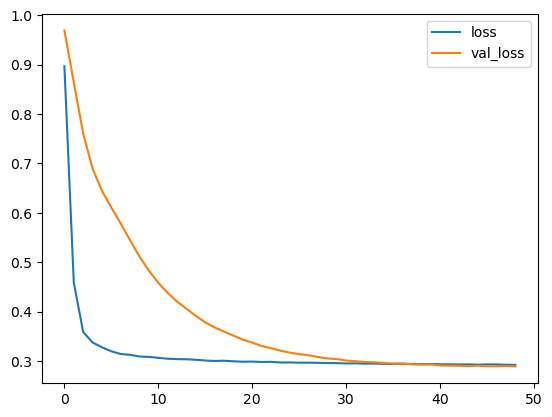

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=20000,
    epochs=100,
    callbacks=[early_stopping],
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_valid, y_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()


Use the model to write out its predictions for all of the data trained upon.

In [11]:
print (X.head())

X_all = X.copy() # we do not want to have to rebuild (run all) this, so protect the original

features_num = [
    "product_price", "Review"
]
features_cat = [
    "Rate"
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0.0), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

X_all['product_price'] = X_all['product_price'] = pd.to_numeric(X_all['product_price'], errors='coerce').astype(float).fillna(0.0)
X_all['Rate'] = X_all['Rate'] = pd.to_numeric(X_all['Rate'], errors='coerce').astype(int).fillna(0)
X_all['Review'] = X_all['Review'] = pd.to_numeric(X_all['Review'], errors='coerce').astype(int).fillna(0)

X_all = preprocessor.fit_transform(X_all)

y_pred = model.predict(X_all) # run a prediction on all rows

print(y_pred) # reminder, one over 0.5 is the answer [ neutral positive negative ]

ufkdf = fkdf.copy()

ufkdf['NN-sentiment'] = "unknown"

total_changed = 0
total_pos2neu = 0
total_pos2neg = 0
total_neu2pos = 0
total_neu2neg = 0
total_neg2neu = 0
total_neg2pos = 0
for i in range(len(ufkdf)):
    if i % 10000 == 0:
        print("Updating DF results completed ", i, " of ", len(ufkdf))
    if y_pred[i][0] >= 0.5: # prediction is now neutral
        ufkdf.loc[i, "NN-sentiment"] = "neutral"
        if ufkdf.loc[i, "Sentiment"] == "positive":
            total_changed = total_changed + 1
            total_pos2neu = total_pos2neu + 1
        if ufkdf.loc[i, "Sentiment"] == "negative":
            total_changed = total_changed + 1
            total_neg2neu = total_neg2neu + 1
    elif y_pred[i][1] >= 0.5: # prediction is now positive
        ufkdf.loc[i, "NN-sentiment"] = "positive"
        if ufkdf.loc[i, "Sentiment"] == "neutral":
            total_changed = total_changed + 1
            total_neu2pos = total_neu2pos + 1
        if ufkdf.loc[i, "Sentiment"] == "negative":
            total_changed = total_changed + 1
            total_neg2pos = total_neg2pos + 1
    elif y_pred[i][2] >= 0.5: # prediction is now negative
        ufkdf.loc[i, "NN-sentiment"] = "negative"
        if ufkdf.loc[i, "Sentiment"] == "neutral":
            total_changed = total_changed + 1
            total_neu2neg = total_neu2neg + 1
        if ufkdf.loc[i, "Sentiment"] == "positive":
            total_changed = total_changed + 1
            total_pos2neg = total_pos2neg + 1
            
print("There were a total of ", total_changed, " changes in sentiment")
print("Accuracy against the full training set is ", 1.0 - (total_changed / len(ufkdf)))
print(" ")
print("Total changed from positive to neutral ", total_pos2neu)
print("Total changed from positive to negative ", total_pos2neg)
print("Total changed from neutral to positive ", total_neu2pos)
print("Total changed from neutral to negative ", total_neu2neg)
print("Total changed from negative to neutral ", total_neg2neu)
print("Total changed from negative to positive ", total_neg2pos)


   product_price Review Rate
0         3999.0    1.0    5
1         3999.0    2.0    5
2         3999.0    3.0    3
3         3999.0    4.0    1
4         3999.0    3.0    3
6408/6408 [==============================] - 6s 987us/step
[[0.0210998  0.97184676 0.00705348]
 [0.02103626 0.9719301  0.00703375]
 [0.25094265 0.54749525 0.2015621 ]
 ...
 [0.26364768 0.55494535 0.18140702]
 [0.26364768 0.55494535 0.18140702]
 [0.26364768 0.55494535 0.18140702]]
Updating DF results completed  0  of  205052
Updating DF results completed  10000  of  205052
Updating DF results completed  20000  of  205052
Updating DF results completed  30000  of  205052
Updating DF results completed  40000  of  205052
Updating DF results completed  50000  of  205052
Updating DF results completed  60000  of  205052
Updating DF results completed  70000  of  205052
Updating DF results completed  80000  of  205052
Updating DF results completed  90000  of  205052
Updating DF results completed  100000  of  205052
Updating 

In [12]:
print(ufkdf.nunique) # should have 3 for NN-sentiment showing no "unknowns" remain.

#ufkdf.to_csv('flipkart-results.csv') # uncomment me to write the results to a CSV vile

<bound method DataFrame.nunique of                                              product_name  product_price Rate  \
0       Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
1       Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    5   
2       Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   
3       Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    1   
4       Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0    3   
...                                                   ...            ...  ...   
205050  cello Pack of 18 Opalware Cello Dazzle Lush Fi...         1299.0    5   
205051  cello Pack of 18 Opalware Cello Dazzle Lush Fi...         1299.0    4   
17299                                                 NaN            0.0    3   
175895                                                NaN            0.0    3   
175906                                                NaN            0.0  